In [1]:
import argparse
import logging
import os
import random
import sys
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
from pathlib import Path
from torch import optim


from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# PyTorch TensorBoard support
#from torch.utils.tensorboard import SummaryWriter
from datetime import datetime

from torchvision.datasets import ImageFolder
from tqdm import tqdm   # show loops progress

#import wandb    # track and visualize aspects of training proccess in real time
#import evaluate
from unet import UNet
#from utils.data_loading import BasicDataset, CarvanaDataset

In [2]:
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA version from PyTorch: {torch.version.cuda}")

PyTorch version: 2.5.1
CUDA version from PyTorch: 12.1


**LOAD TRAIN DATA**

In [3]:
# Dataset personalizado para DRIVE
class Dataset(Dataset):
    def __init__(self, image_dir, ground_truth, transform=None):
        self.image_dir = image_dir
        self.ground_truth_dir = ground_truth
        self.image_filenames = os.listdir(image_dir)  
        self.mask_filenames = os.listdir(ground_truth)   
        self.transform = transform

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        image_path = os.path.join(self.image_dir, self.image_filenames[idx])
        ground_truth_path = os.path.join(self.ground_truth_dir, self.mask_filenames[idx])
        
        image = Image.open(image_path).convert('RGB')
        ground_truth = Image.open(ground_truth_path).convert('L')  # gt to grayscale
        
        if self.transform:
            image = self.transform(image)
            ground_truth = self.transform(ground_truth)

        return image, ground_truth, self.image_filenames[idx]


IMG_SIZE = 512

# transforms for images and its vessel segmentations
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    # transforms.Grayscale(num_output_channels=1),       # we want rgb
    transforms.ToTensor()
])

# Routes for training data
image_dir = './data/CHASE/training/images'
ground_truth_dir = './data/CHASE/training/1st_manual'

dataset = Dataset(image_dir, ground_truth_dir, transform=transform)

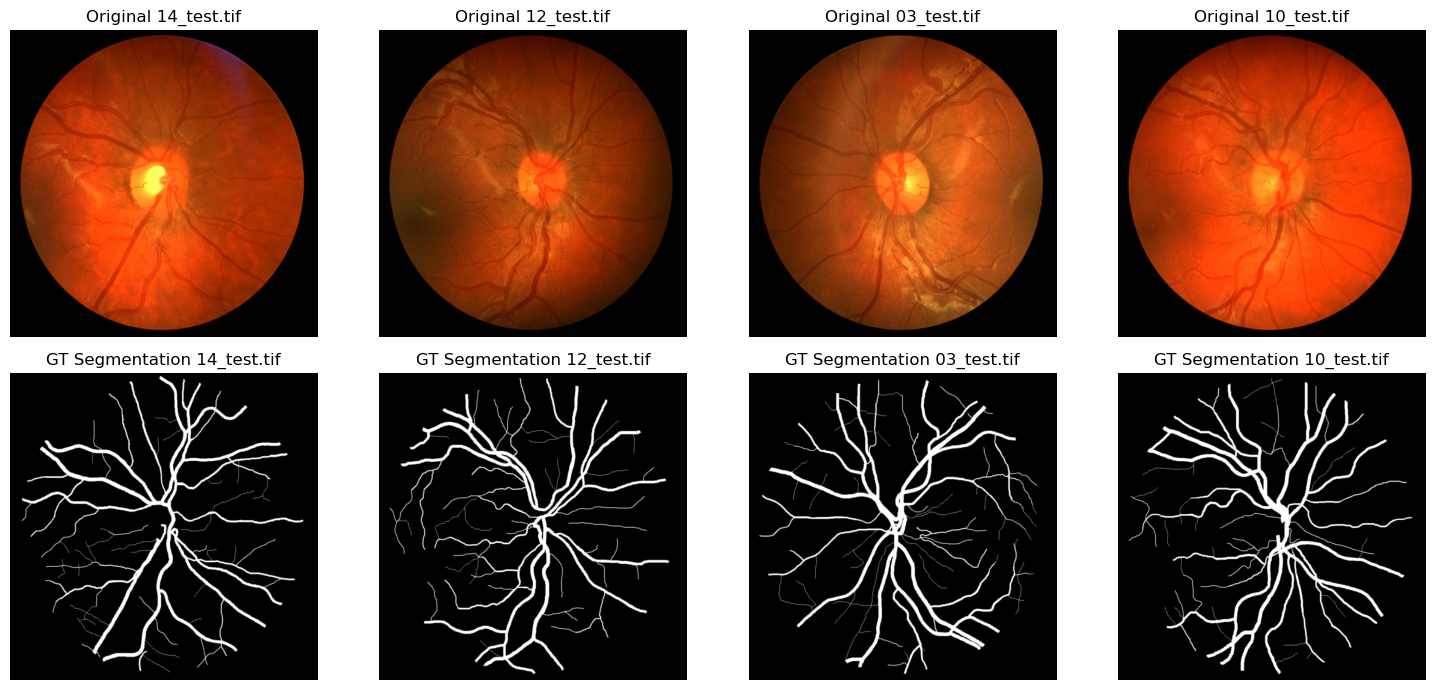

In [4]:
example_loader = DataLoader(dataset, batch_size=8, shuffle=True, num_workers=0)

# Obtener algunas imágenes y máscaras del example_loader
data_iter = iter(example_loader)
images, ground_truth, img_name = next(data_iter)

# Convertir los tensores a formato numpy para visualizarlos
images = images.numpy().transpose(0, 2, 3, 1)  # [N, C, H, W] a [N, H, W, C]
ground_truth = ground_truth.numpy()  # [N, H, W] para las máscaras

# Eliminar la dimensión extra (1, H, W) de las máscaras
ground_truth = np.squeeze(ground_truth)  # Esto convierte la forma (1, H, W) a (H, W)

# Visualizar las imágenes en la fila superior y las máscaras en la fila inferior
fig, axes = plt.subplots(2, 4, figsize=(15, 7))  # 2 filas, 4 columnas (imágenes arriba y máscaras abajo)

for i in range(4):
    # Mostrar la imagen en la fila superior
    axes[0, i].imshow(images[i])
    axes[0, i].axis('off')
    axes[0, i].set_title(f'Original {img_name[i]}')
    
    # Mostrar la máscara en la fila inferior
    axes[1, i].imshow(ground_truth[i], cmap='gray')  # show as grayscale
    axes[1, i].axis('off')
    axes[1, i].set_title(f'GT Segmentation {img_name[i]}')

plt.tight_layout()
plt.show()

**DATA SPLITTING**

In [5]:
VAL_PERCENT:float = 0.2            # Percentage of dataset intended for validation (rest is for training) 
BATCH_SIZE:int = 4

# Split into train / validation partitions
val_size = int(len(dataset) * VAL_PERCENT)     # number of samples for validation
train_size = len(dataset) - val_size           # number of samples for training
train_set, val_set = random_split(dataset, [train_size, val_size], generator=torch.Generator().manual_seed(0))

# Create data loaders for our datasets; shuffle for training, not for validation
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False)

print('Training set has {} instances'.format(train_size))
print('Validation set has {} instances'.format(val_size))

Training set has 16 instances
Validation set has 4 instances


In [7]:
sample_image, sample_gt, _ = train_set[0]

NUM_CHANNELS_IN:int = sample_image.size(0)  
NUM_CHANNELS_OUT:int = sample_gt.size(0)

print(f"Number of channels in input: {NUM_CHANNELS_IN}")
print(f"Number of channels in output: {NUM_CHANNELS_OUT}")

Number of channels in input: 3
Number of channels in output: 1


**CREATE MODEL**

In [8]:
from unet import UNet
model = UNet(n_channels=NUM_CHANNELS_IN, n_classes=NUM_CHANNELS_OUT)

# cuda if available, cpu if not
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"{device.type=}")
model.to(device)      # move to cuda if possible

from torchsummary import summary
summary(model, (NUM_CHANNELS_IN, IMG_SIZE, IMG_SIZE))

device.type='cuda'
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 512, 512]           1,792
       BatchNorm2d-2         [-1, 64, 512, 512]             128
              ReLU-3         [-1, 64, 512, 512]               0
            Conv2d-4         [-1, 64, 512, 512]          36,928
       BatchNorm2d-5         [-1, 64, 512, 512]             128
              ReLU-6         [-1, 64, 512, 512]               0
             Block-7         [-1, 64, 512, 512]               0
        InputBlock-8         [-1, 64, 512, 512]               0
         MaxPool2d-9         [-1, 64, 256, 256]               0
           Conv2d-10        [-1, 128, 256, 256]          73,856
      BatchNorm2d-11        [-1, 128, 256, 256]             256
             ReLU-12        [-1, 128, 256, 256]               0
           Conv2d-13        [-1, 128, 256, 256]         147,584
      BatchNorm2d-14

**SOME HYPERPARAMETERS, SAVE PATH, CUDA**

In [9]:
EPOCHS:int = 100

# optimizer
LEARNING_RATE:float = 0.001
MOMENTUM:float = 0.9

# save best model state path
SAVE_PATH = "./trained_models"
       

loss_fn = torch.nn.BCELoss()        # binary cross-entropy loss (need sigmoid at the end of network)
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)

**TRAIN FUNCTION**

In [10]:
def training_loop(epochs, model, train_dataloader, val_dataloader, 
                  loss_fn, optimizer, save_path):
    
    history = {'train_loss': [], 'val_loss': [], 'train_accuracy':[], 'val_accuracy':[]}
    best_val_loss = float('inf')  # Initialize to infinity
    best_model_state = None

    for epoch in range(1, epochs+1):
        model.train()
        running_train_loss = 0
        train_correct_pred = 0
        total_train_pred = 0
        
        for data in tqdm(train_dataloader):      # for each training batch
            
            img, ground_truth = data
            img, ground_truth = img.to(device), ground_truth.to(device)     # move to cuda, if possible
            
            pred = model(img)
            loss = loss_fn(pred, ground_truth)
            
            running_train_loss += loss.item()
            train_correct_pred += ((pred > 0.5).float() == ground_truth).sum()      # add number of correct predictions
            total_train_pred += IMG_SIZE*IMG_SIZE*len(img)            # add number of predictions made (pixels per img * number of imgs)
            
            loss.backward()            # calculate gradients
            optimizer.step()           # update model parameters
            optimizer.zero_grad()      # reset gradients
        
        model.eval()
        with torch.no_grad():
            running_val_loss = 0
            val_correct_pred = 0
            total_val_pred = 0
            
            for data in tqdm(val_dataloader):      # for each validation batch
                
                img, ground_truth = data
                img, ground_truth = img.to(device), ground_truth.to(device)       # move to cuda, if possible
                
                pred = model(img)
                loss = loss_fn(pred, ground_truth)
                
                running_val_loss += loss.item()
                val_correct_pred += ((pred > 0.5).float() == ground_truth).sum()         # add number of correct predictions
                total_val_pred += IMG_SIZE*IMG_SIZE*len(img)                     # add number of predictions made (pixels per img * number of imgs)


        train_loss = running_train_loss / len(train_dataloader.dataset)
        val_loss = running_val_loss / len(val_dataloader.dataset)
        train_acc = train_correct_pred / total_train_pred * 100       # % of average accuracy in training, in this epoch
        val_acc = val_correct_pred / total_val_pred * 100             # % of average accuracy in validation, in this epoch

        history['train_loss'].append(train_loss)         # add metrics in this epoch to the record
        history['val_loss'].append(val_loss)
        history['train_accuracy'].append(train_acc)
        history['val_accuracy'].append(val_acc)
        
        print(f'Epoch: {epoch}/{epochs} | Training loss: {train_loss:.4f} | Validation loss: {val_loss:.4f} | Training accuracy: {train_acc:.2f} | Validation accuracy: {val_acc:.2f}')
        print(f"\n")
        
        # Save the model if the validation loss improved
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict()  # Save the model state

    # Save the best model state
    if best_model_state is not None:
        model_path = save_path+'/'+'model_{}_{}'.format(type(model).__name__, datetime.now().strftime('%Y%m%d_%H%M%S'))
        torch.save(best_model_state, model_path)
        print(f'\nBest model saved at {model_path}')
    
    model.eval()
    return history

In [ ]:
# TRAIN THE MODEL
history = training_loop(EPOCHS, model, train_loader, val_loader, 
                        loss_fn, optimizer, SAVE_PATH)

In [ ]:
plt.figure(figsize=(7, 7))
plt.plot(np.arange(1,EPOCHS+1), history['train_loss'], label='Training loss')
plt.plot(np.arange(1,EPOCHS+1), history['val_loss'], label='Validation loss')
interval = 10 
plt.xticks(np.arange(1, EPOCHS + 1, interval))
plt.xlabel("Epochs")
plt.grid()
plt.legend()
plt.show()

In [ ]:
# from tensor to numpy
train_accuracy_cpu = [acc.cpu().numpy() for acc in history['train_accuracy']]
val_accuracy_cpu = [acc.cpu().numpy() for acc in history['val_accuracy']]
print(train_accuracy_cpu)

plt.figure(figsize=(7, 7))
plt.plot(np.arange(1,EPOCHS+1), train_accuracy_cpu, label='Training accuracy')
plt.plot(np.arange(1,EPOCHS+1), val_accuracy_cpu, label='Validation accuracy')
interval = 10 
plt.xticks(np.arange(1, EPOCHS + 1, interval))
plt.xlabel("Epochs")
plt.grid()
plt.legend()
plt.show()

**TEST**

In [11]:
model = UNet(n_channels=NUM_CHANNELS_IN, n_classes=NUM_CHANNELS_OUT)
model.load_state_dict(torch.load('./trained_models\model_UNet_20250119_220445'))
model.to(device)
model.eval()

C:\Users\Usuario\AppData\Local\Temp\ipykernel_6932\959738381.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('./trained_models\model_UNe

UNet(
  (inp): InputBlock(
    (conv): Block(
      (conv): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
    )
  )
  (down1): EncoderBlock(
    (mpconv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): Block(
        (conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
          (4): BatchNorm2d(128, e

In [13]:
test_transform = transforms.Compose([
    #transforms.Resize((512, 512)),  # evaluation at native resolution
    transforms.ToTensor(),
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), 
])

# load test images
test_img_dir = './data/CHASE/test/images'
test_gt_dir = './data/CHASE/test/1st_manual'

test_dataset = Dataset(test_img_dir, test_gt_dir, transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [14]:
#check test image
for img, gt, img_name in test_loader:
    print(f"Shape of image: {img.shape}")
    print(f"Shape of GT: {gt.shape}")
    print(f"Name of image: {img_name[0]}") 
    break  # just one

Shape of image: torch.Size([1, 3, 960, 999])
Shape of GT: torch.Size([1, 1, 960, 999])
Name of image: 01_test.tif


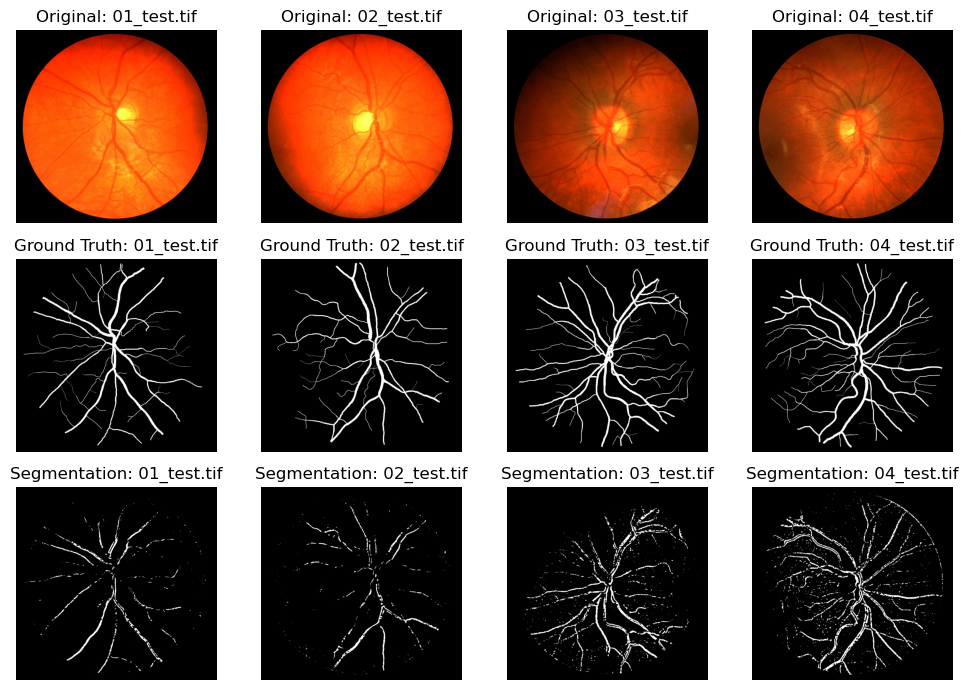

In [15]:
model.eval()   # done before, but just in case...

num_images = 4  # number of images to show
fig, axes = plt.subplots(3, num_images, figsize=(10, 7))

i = 0  # counter

with torch.no_grad():  # no gradient needed
    for image, gt, image_name in test_loader:
        if i >= num_images: 
            break

        # move to cuda
        image = image.to(device)

        output = model(image)  # predict
        output_binary = (output > 0.5).float()  # convert to 0 or 1

        # convert output to image
        output_img = output_binary.squeeze().cpu().numpy()  # delete batch dimension

        # original test images
        axes[0, i].imshow(image.squeeze().cpu().numpy().transpose(1, 2, 0))  # from tensor to image
        axes[0, i].axis('off')
        axes[0, i].set_title(f"Original: {image_name[0]}")
        
        # test images ground truth segmentations
        axes[1, i].imshow(gt.squeeze().cpu().numpy(), cmap='gray')  # grayscale
        axes[1, i].axis('off')
        axes[1, i].set_title(f"Ground Truth: {image_name[0]}")

        # test images predicted segmentations
        axes[2, i].imshow(output_img, cmap='gray')  # grayscale
        axes[2, i].axis('off')
        axes[2, i].set_title(f"Segmentation: {image_name[0]}")

        i += 1

plt.tight_layout()
plt.show()

**ROC, AUC, Dice score**

Mean Dice Score: 0.4360


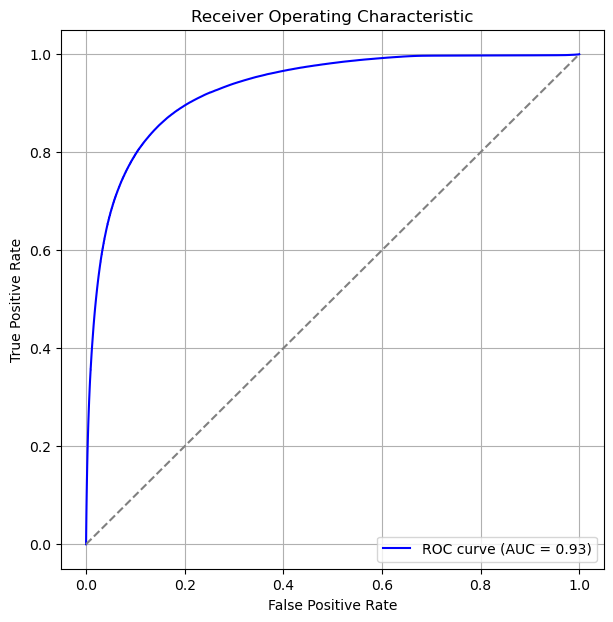

In [16]:
from sklearn.metrics import roc_curve, auc
from utils.dice_score import dice_score      # custom function to calculate dice score

all_labels = []       # to store ground truth values for each pixel of each image
all_preds = []        # to store predicted values for each pixel of each image

dice_scores = []      # to store dice score of each batch

with torch.no_grad():  # no gradients needed
    for inputs, ground_truth, _ in test_loader:        # for each batch in test loader
        inputs = inputs.to(device)
        ground_truth = ground_truth.to(device)

        outputs = model(inputs)     # predict

        all_labels.append(ground_truth.cpu().numpy())  # real labels for each pixel (0 or 1) 
        all_preds.append(outputs.cpu().numpy())    # probabilities to belong to class 1, given by model
        
        dice = dice_score(outputs, ground_truth)
        dice_scores.append(dice.item())

# compute mean dice score and print
mean_dice_score = torch.tensor(dice_scores).mean()
print(f"Mean Dice Score: {mean_dice_score:.4f}")

# list to numpy array
all_labels = np.concatenate(all_labels, axis=0)
all_preds = np.concatenate(all_preds, axis=0)

# ROC curve
fpr, tpr, thresholds = roc_curve(all_labels.flatten(), all_preds.flatten())

# AUC
roc_auc = auc(fpr, tpr)

# plot ROC
plt.figure(figsize=(7, 7))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Línea diagonal
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()